# Kaggle:Yelp:Images
## Create data/train_imgs.csv from data/train.csv & data/train_photo_to_biz.csv
### bdanalytics

In [1]:
format(Sys.time(), "(%a) %b %d, %Y")

[1] "(Fri) Feb 05, 2016"

In [2]:
require(doMC)
glbCores <- 6 # of cores on machine - 2
registerDoMC(glbCores)

require(Cairo)
require(dplyr)
require(ggplot2)
require(jpeg)
require(reshape2)
source("~/Dropbox/datascience/R/myplot.R")

Loading required package: doMC
Loading required package: foreach
Loading required package: iterators
Loading required package: parallel
Loading required package: Cairo
Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: ggplot2
Loading required package: jpeg
Loading required package: reshape2


### Import data files

In [3]:
obsTrn <- read.csv("data/train.csv")
obsTrnImgBiz <- read.csv("data/train_photo_to_biz_ids.csv")
obsNew <- read.csv("data/test.csv")
obsNewImgBiz <- read.csv("data/test_photo_to_biz.csv")

Create separate dataframes for all observations 
    - obsAll:       non-images data
    - obsAllImgBiz: photo_id to biz_id only
    - obsAllImg:    images only

In [4]:
obsTrn$.src <- "Train"; obsTrnImgBiz$.src <- "Train"
obsNew$.src <- "Test" ; obsNewImgBiz$.src <- "Test"

obsAll <- myrbind_df(obsTrn, obsNew)
print("obsAll:")
print(table(obsAll$.src, useNA = "ifany"))
print(" ")
print("obsAllImgBiz:")
obsAllImgBiz <- myrbind_df(obsTrnImgBiz, obsNewImgBiz)
print(table(obsAllImgBiz$.src, useNA = "ifany"))

[1] "obsAll:"

 Test Train 
10000  2000 
[1] " "
[1] "obsAllImgBiz:"

   Test   Train 
1190225  234842 


In [5]:
obsAllImg <- obsAllImgBiz[, c('photo_id', '.src'), FALSE]
print(table(obsAllImg$.src, useNA = "ifany"))
obsAllImg <- dplyr::distinct(obsAllImgBiz, photo_id) %>%
             dplyr::select(-business_id)
print(table(obsAllImg$.src, useNA = "ifany"))


   Test   Train 
1190225  234842 

  Test  Train 
237152 234842 


### Inspect data

How many (& Which) businesses are duplicated across Train & Test ?

In [6]:
obsAllDups <- gdata::duplicated2(obsAll$business_id)
print(table(obsAllDups, obsAll$.src, useNA = "ifany"))

          
obsAllDups  Test Train
     FALSE 10000  2000


How many (& Which) images are duplicated across Train & Test ?

In [7]:
obsAllImgDups <- gdata::duplicated2(obsAllImg)
print(nrow(obsAllImgDups))
#print(table(obsAllImgDups, obsAllImgBiz$.src, useNA = "ifany"))

NULL


Which images are duplicated (chain - chn) across restaurants ?

In [8]:
obsAllImgBiz$chn <- gdata::duplicated2(obsAllImgBiz$photo_id)
print(table(obsAllImgBiz$chn, obsAllImgBiz$.src, useNA = "ifany"))

       
           Test   Train
  FALSE    4325  234842
  TRUE  1185900       0


In [9]:
obsAllImgBiz[obsAllImgBiz$chn & obsAllImgBiz$.src == "Test", ] %>%
    dplyr::count(photo_id) %>%
    arrange(desc(n)) %>%
    head() %>%
    print()

Source: local data frame [6 x 2]

  photo_id     n
     (int) (int)
1    91974    16
2   182938    16
3   235151    16
4   426819    16
5     7545    15
6    24198    15


ERROR: Error in file(con, "rb"): cannot open the connection


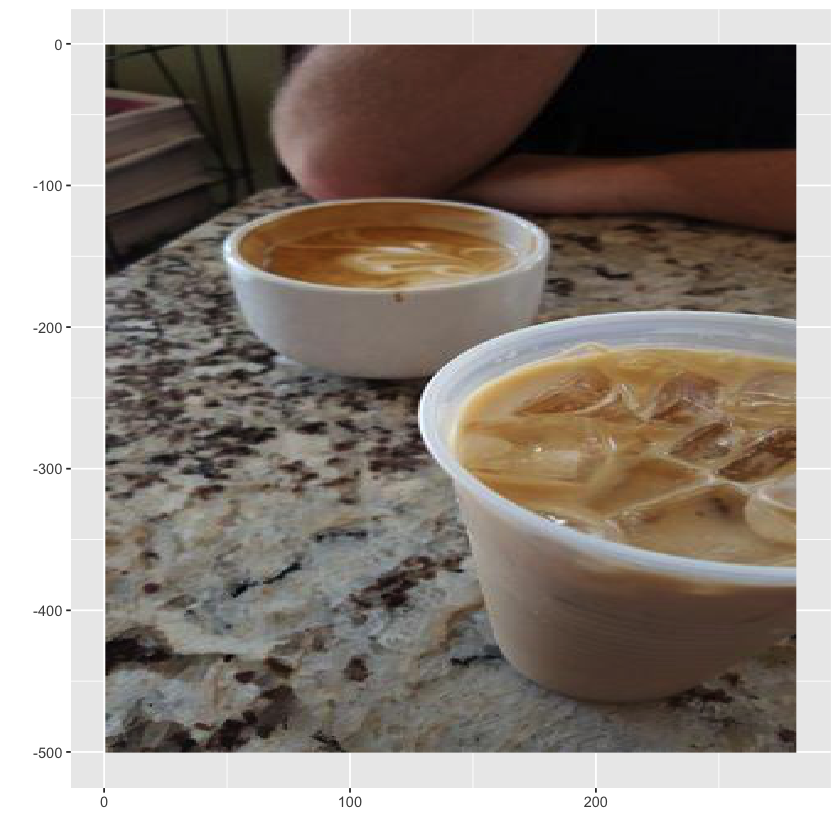

In [10]:
print(myplotImg(img <- readJPEG("data/photos/91974.jpg")))

ERROR: Error in file(con, "rb"): cannot open the connection


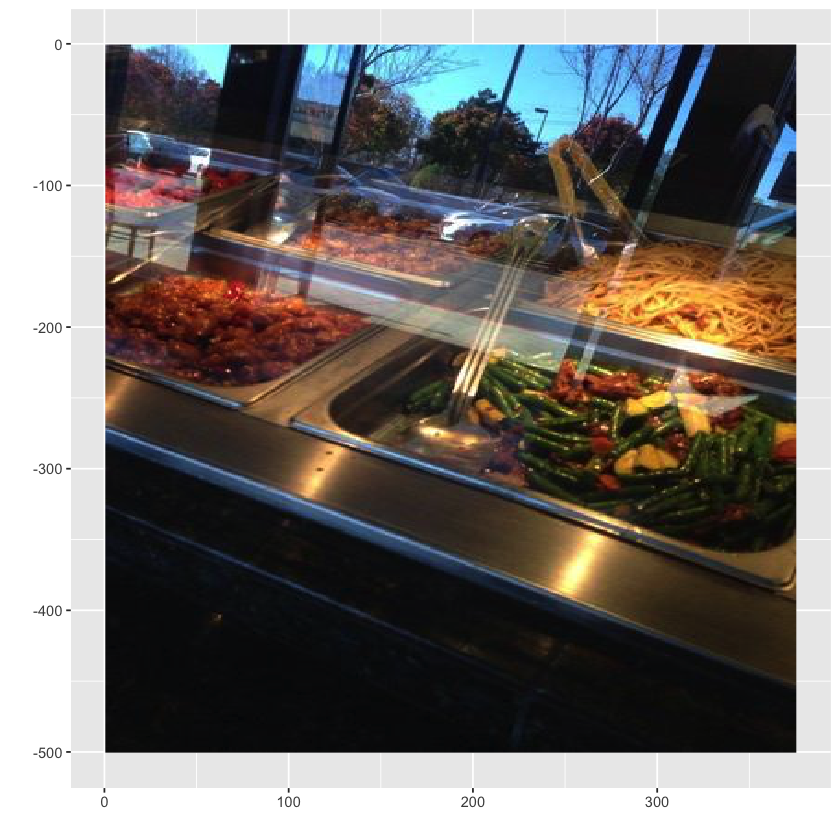

In [11]:
print(myplotImg(img <- readJPEG("data/photos/182938.jpg")))

ERROR: Error in file(con, "rb"): cannot open the connection


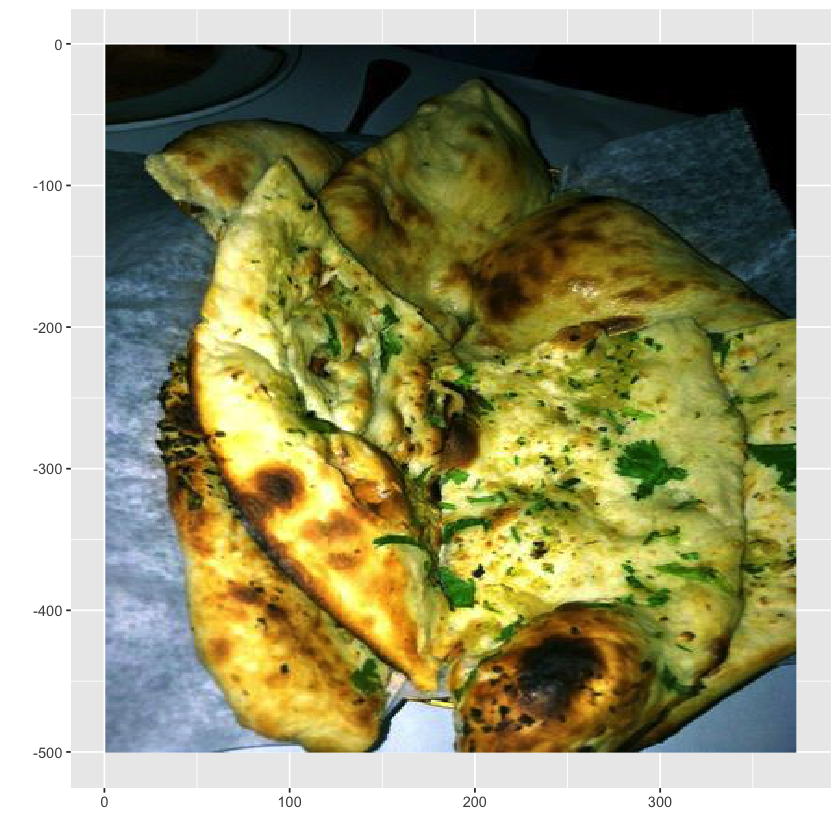

In [12]:
print(myplotImg(img <- readJPEG("data/photos/235151.jpg")))

ERROR: Error in file(con, "rb"): cannot open the connection


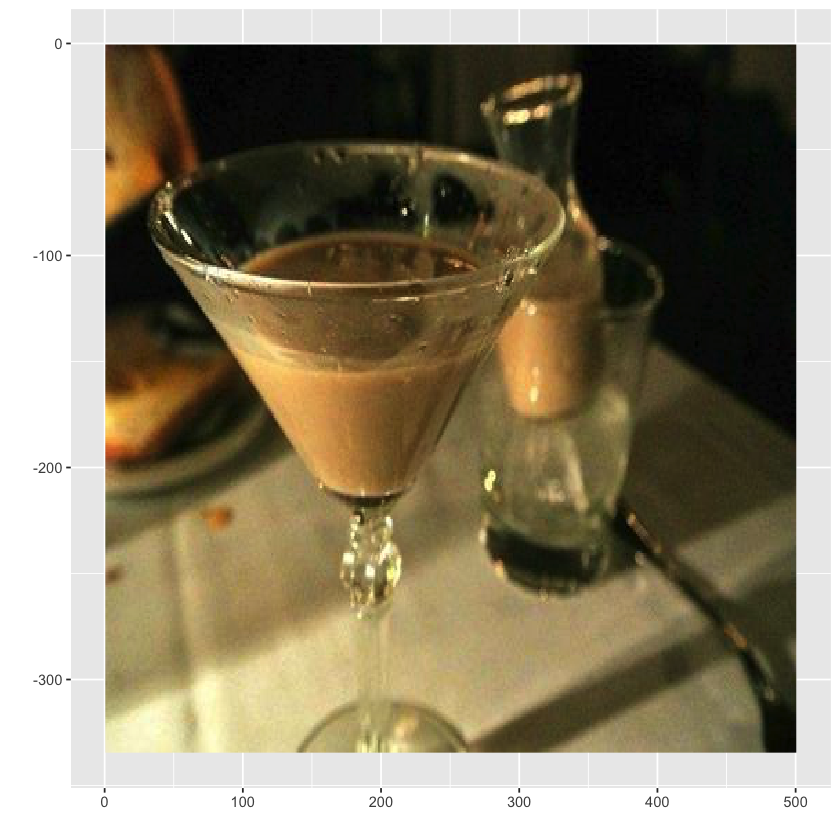

In [13]:
print(myplotImg(img <- readJPEG("data/photos/426819.jpg")))

In [14]:
print(class(img)); print(dim(img))
print(img[1:5, 1:5, 1])

[1] "array"
[1] 334 500   3
          [,1]      [,2]      [,3]      [,4]      [,5]
[1,] 0.3921569 0.3686275 0.3333333 0.3254902 0.3254902
[2,] 0.4196078 0.3960784 0.3607843 0.3450980 0.3372549
[3,] 0.4352941 0.4117647 0.3843137 0.3686275 0.3529412
[4,] 0.4117647 0.4000000 0.3921569 0.3764706 0.3725490
[5,] 0.4000000 0.3960784 0.3921569 0.3843137 0.3764706


### Summarize Image data to businesses

#### nImgs

In [15]:
nImgsAll <-
    #obsAllImgBiz[1:10, c("photo_id", "business_id")] %>%
    obsAllImgBiz[, c("photo_id", "business_id")] %>%
    dplyr::group_by(business_id) %>%
    dplyr::summarize(nImgs = n_distinct(photo_id))

print(summary(nImgsAll$nImgs))
print(tapply(nImgsAll$nImgs, obsAll$.src, FUN = summary))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0    32.0    60.0   118.8   120.0  2974.0 
$Test
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1      32      59     118     120    2825 

$Train
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0    33.0    61.5   122.4   121.0  2974.0 



In [16]:
obsAll <- dplyr::left_join(obsAll, nImgsAll)
print(tapply(obsAll$nImgs, obsAll$.src, summary))
myprint_df(obsAll)

Joining by: "business_id"


$Test
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1      32      60     119     120    2825 

$Train
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    2.0    34.0    61.0   117.4   117.0  2974.0 

  business_id        labels  .src nImgs
1        1000 1 2 3 4 5 6 7 Train    54
2        1001       0 1 6 8 Train     9
3         100   1 2 4 5 6 7 Train    84
4        1006     1 2 4 5 6 Train    22
5        1010         0 6 8 Train    11
6         101   1 2 3 4 5 6 Train   121
      business_id labels .src nImgs
2014        01s0p   <NA> Test   132
3083        3vvch   <NA> Test    27
5565        cnb8g   <NA> Test    60
6625        gkb3z   <NA> Test    44
9245        pzcij   <NA> Test   213
11780       z7uim   <NA> Test    61
      business_id labels .src nImgs
11995       zyrif   <NA> Test    89
11996       zyvg6   <NA> Test    16
11997       zyvjj   <NA> Test    27
11998       zz8g4   <NA> Test   118
11999       zzxkg   <NA> Test   154
12000       zzxwm   <NA> Test    13


#### imgRes[X|Y|XY]
#### imgLum[R|B|G].[mean|mad]; imgCor[RB|BG|GR]

In [17]:
savobsAllImg <- obsAllImg; print(all.equal(savobsAllImg, obsAllImg))

[1] TRUE


In [18]:
#obsAllImg <- savobsAllImg
myprint_df(obsAllImg)

  photo_id  .src
1   204149 Train
2    52779 Train
3   278973 Train
4   195284 Train
5    19992 Train
6    80748 Train
       photo_id  .src
87603    354100 Train
187943    90003 Train
191758   381171 Train
236370   121390  Test
247995   349193  Test
397990   139074  Test
       photo_id .src
471989    87954 Test
471990   157255 Test
471991   164647 Test
471992   439142 Test
471993   297463 Test
471994   274169 Test


In [22]:
print(img[1:5, 1:5, 1])
#cor(as.vector(img[,,1]), as.vector(img[,,2]))
#proxy::simil(x = as.vector(img[,,1]), y = as.vector(img[,,2]), method = "cosine")
# print(as.vector(proxy::simil(rbind(as.vector(img[1:5,1:5,1]), as.vector(img[1:5,1:5,2])), 
#                              method = "cosine")))
# print(as.vector(proxy::simil(rbind(as.vector(img[,,1]), as.vector(img[,,2])), 
#                              method = "cosine")))

          [,1]      [,2]      [,3]      [,4]      [,5]
[1,] 0.3921569 0.3686275 0.3333333 0.3254902 0.3254902
[2,] 0.4196078 0.3960784 0.3607843 0.3450980 0.3372549
[3,] 0.4352941 0.4117647 0.3843137 0.3686275 0.3529412
[4,] 0.4117647 0.4000000 0.3921569 0.3764706 0.3725490
[5,] 0.4000000 0.3960784 0.3921569 0.3843137 0.3764706
[1] 0.9994428
[1] 0.9951433


In [19]:
require(proxy)

Loading required package: proxy

Attaching package: ‘proxy’

The following objects are masked from ‘package:stats’:

    as.dist, dist

The following object is masked from ‘package:base’:

    as.matrix



In [24]:
startTm <- proc.time()["elapsed"]
nImages <- nrow(obsAllImg) 
ftsAllImg <- foreach(imgIx = 1:nImages, .combine = rbind) %dopar% {
#ftsAllImg <- foreach(imgIx = 1:5, .combine = rbind) %do% {    
    img <- readJPEG(sprintf("data/photos/%d.jpg", 
                            obsAllImg[imgIx, 'photo_id']))
    ftsThsImg <- data.frame('imgResY'  = dim(img)[1],
                            'imgResX'  = dim(img)[2],
                            'imgResXY' = dim(img)[2] * dim(img)[1]
                            
                           ,'imgLumR.mean' = mean(img[,,1])
                           ,'imgLumR.mad'  = mad (img[,,1])    
                           ,'imgLumB.mean' = mean(img[,,2])
                           ,'imgLumB.mad'  = mad (img[,,2])    
                           ,'imgLumG.mean' = mean(img[,,3])
                           ,'imgLumG.mad'  = mad (img[,,3]) 
                            
                ,'imgCorRB' = cor(as.vector(img[,,1]), as.vector(img[,,2]))
                ,'imgCorBG' = cor(as.vector(img[,,2]), as.vector(img[,,3]))
                ,'imgCorGR' = cor(as.vector(img[,,3]), as.vector(img[,,1]))
                            
                ,'imgCosSmlRB' = 
                    as.vector(proxy::simil(rbind(as.vector(img[,,1]), as.vector(img[,,2])), 
                                            method = "cosine"))
                ,'imgCosSmlBG' = 
                    as.vector(proxy::simil(rbind(as.vector(img[,,2]), as.vector(img[,,3])), 
                                            method = "cosine"))
                ,'imgCosSmlGR' = 
                    as.vector(proxy::simil(rbind(as.vector(img[,,3]), as.vector(img[,,1])), 
                                            method = "cosine"))
                           )    
}
myprint_df(ftsAllImg)
print(sprintf("Finished reading images:%d elapsed seconds:%0.0f",
      nrow(ftsAllImg), proc.time()["elapsed"] - startTm))

  imgResY imgResX imgResXY imgLumR.mean imgLumR.mad imgLumB.mean imgLumB.mad
1     500     373   186500    0.5083072   0.2267506    0.4673910   0.2965200
2     500     500   250000    0.4169495   0.5116424    0.2604018   0.1395388
3     375     500   187500    0.2577210   0.1511671    0.1836261   0.0988400
4     375     500   187500    0.4568185   0.3197765    0.4619201   0.3255906
5     375     500   187500    0.4356761   0.1918659    0.4836980   0.1860518
6     375     500   187500    0.3330310   0.1569812    0.2734042   0.1453529
  imgLumG.mean imgLumG.mad  imgCorRB  imgCorBG  imgCorGR imgCosSmlRB
1    0.4154729  0.34884706 0.9679110 0.9773676 0.9092199   0.9908007
2    0.2731843  0.20930824 0.8979718 0.9316769 0.9152002   0.9372394
3    0.1524044  0.05232706 0.9091581 0.9561837 0.7819084   0.9518613
4    0.4241791  0.30814824 0.9783621 0.9858568 0.9458435   0.9945510
5    0.4054324  0.20930824 0.9617356 0.9359308 0.9515275   0.9923045
6    0.2245359  0.16279529 0.9071524 0.9774126 

In [27]:
save(ftsAllImg, file = "data/color_ftsAllImg.RData")

In [28]:
# all.equal(savobsAllImg[1:2000, c('photo_id','.src','resY','resX','resXY')], 
#           obsAllImg[         , c('photo_id','.src','resY','resX','resXY')])
myprint_df(obsAllImg)

  photo_id  .src
1   204149 Train
2    52779 Train
3   278973 Train
4   195284 Train
5    19992 Train
6    80748 Train
       photo_id  .src
62921    162049 Train
86475    303984 Train
190242   354566 Train
215464   212990 Train
398354   418654  Test
408508   273162  Test
       photo_id .src
471989    87954 Test
471990   157255 Test
471991   164647 Test
471992   439142 Test
471993   297463 Test
471994   274169 Test


In [29]:
obsAllImg <- cbind(obsAllImg, ftsAllImg)
myprint_df(obsAllImg)

  photo_id  .src imgResY imgResX imgResXY imgLumR.mean imgLumR.mad imgLumB.mean
1   204149 Train     500     373   186500    0.5083072   0.2267506    0.4673910
2    52779 Train     500     500   250000    0.4169495   0.5116424    0.2604018
3   278973 Train     375     500   187500    0.2577210   0.1511671    0.1836261
4   195284 Train     375     500   187500    0.4568185   0.3197765    0.4619201
5    19992 Train     375     500   187500    0.4356761   0.1918659    0.4836980
6    80748 Train     375     500   187500    0.3330310   0.1569812    0.2734042
  imgLumB.mad imgLumG.mean imgLumG.mad  imgCorRB  imgCorBG  imgCorGR
1   0.2965200    0.4154729  0.34884706 0.9679110 0.9773676 0.9092199
2   0.1395388    0.2731843  0.20930824 0.8979718 0.9316769 0.9152002
3   0.0988400    0.1524044  0.05232706 0.9091581 0.9561837 0.7819084
4   0.3255906    0.4241791  0.30814824 0.9783621 0.9858568 0.9458435
5   0.1860518    0.4054324  0.20930824 0.9617356 0.9359308 0.9515275
6   0.1453529    0.2245359

In [30]:
print(summary(obsAllImg))

    photo_id          .src              imgResY         imgResX     
 Min.   :     1   Length:471994      Min.   : 29.0   Min.   : 53.0  
 1st Qu.:117999   Class :character   1st Qu.:375.0   1st Qu.:375.0  
 Median :235998   Mode  :character   Median :428.0   Median :500.0  
 Mean   :235998                      Mean   :427.4   Mean   :440.6  
 3rd Qu.:353996                      3rd Qu.:500.0   3rd Qu.:500.0  
 Max.   :471994                      Max.   :500.0   Max.   :500.0  
                                                                    
    imgResXY       imgLumR.mean     imgLumR.mad      imgLumB.mean   
 Min.   :  1802   Min.   :0.0000   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:186500   1st Qu.:0.4046   1st Qu.:0.1628   1st Qu.:0.3303  
 Median :187500   Median :0.4990   Median :0.2326   Median :0.4172  
 Mean   :184589   Mean   :0.4982   Mean   :0.2371   Mean   :0.4156  
 3rd Qu.:187500   3rd Qu.:0.5945   3rd Qu.:0.3023   3rd Qu.:0.5013  
 Max.   :250000   Max.   :1.0000  

In [51]:
# Fix NA's above, if any
print(subset(obsAllImg, is.na(imgCorRB)))

       photo_id  .src imgResY imgResX imgResXY imgLumR.mean imgLumR.mad
11771    450542 Train     500     373   186500   1.00000000           0
13237     38224 Train     375     500   187500   1.00000000           0
15715    269158 Train     373     500   186500   1.00000000           0
86167    148777 Train     125     354    44250   0.00000000           0
213930   284212 Train     375     500   187500   1.00000000           0
237513   187742  Test     500     281   140500   0.00000000           0
268335   188022  Test     500     500   250000   0.04313725           0
273824   229640  Test     500     330   165000   0.04313725           0
300701   206461  Test     500     281   140500   0.00000000           0
304018   313320  Test     500     373   186500   1.00000000           0
323848   145043  Test     500     375   187500   1.00000000           0
334828   383399  Test     330     500   165000   0.04313725           0
370401   405408  Test     500     281   140500   0.00000000     

ERROR: Error in file(con, "rb"): cannot open the connection


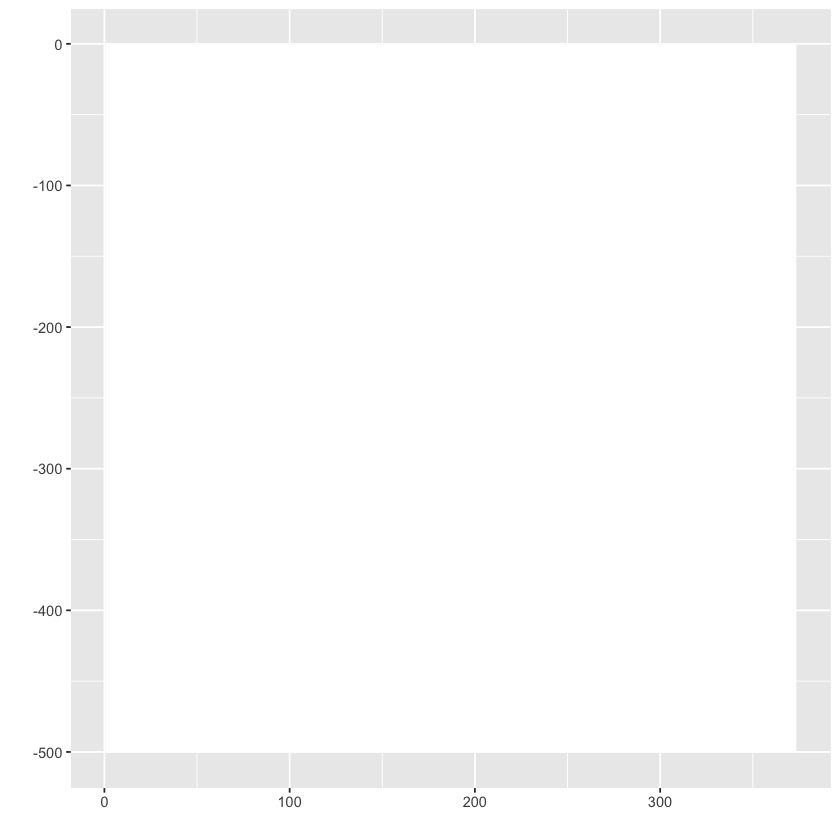

In [54]:
#450542
print(myplotImg(img <- readJPEG(sprintf("data/photos/%d.jpg", 450542))))

In [58]:
length(unique(as.vector(img)))

[1] 1

In [34]:
#print(tapply(obsAllImg$resXY, obsAllImg$.src, FUN = summary))
grep("^img", names(obsAllImg), value = TRUE)

[1] "imgResY"      "imgResX"      "imgResXY"     "imgLumR.mean" "imgLumR.mad" 
 [6] "imgLumB.mean" "imgLumB.mad"  "imgLumG.mean" "imgLumG.mad"  "imgCorRB"    
[11] "imgCorBG"     "imgCorGR"     "imgCosSmlRB"  "imgCosSmlBG"  "imgCosSmlGR"

Warning message:
In myplot_violin(obsAllImg, grep("^img", names(obsAllImg), value = TRUE), : xcol_name:.src is not a factor; creating .src_fctrWarning message:
: Removed 51 rows containing non-finite values (stat_ydensity).Warning message:
: Removed 51 rows containing non-finite values (stat_summary).

ERROR: Error in file(con, "rb"): cannot open the connection


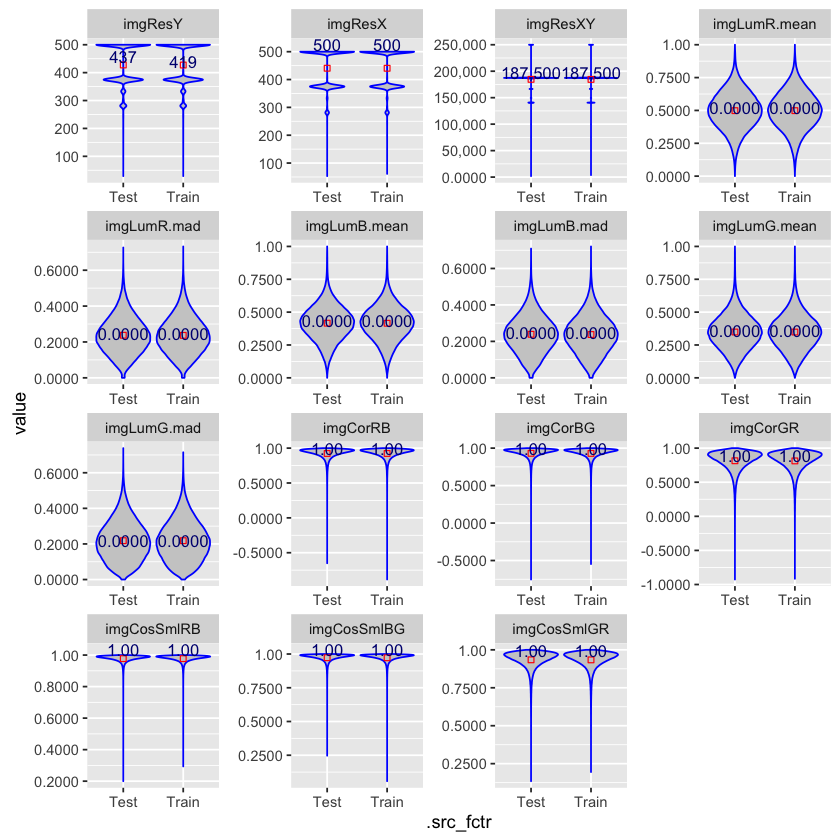

In [35]:
print(myplot_violin(obsAllImg, grep("^img", names(obsAllImg), value = TRUE), ".src"))
#print(myplot_violin(obsAllImg, c("resXY"), ".src"))

In [36]:
#source("~/Dropbox/datascience/R/myplot.R")

[1] "\nSample images for min.imgResY:"
[1] "  nrow(smpImgs): 2"
      photo_id  .src imgResY imgResX imgResXY imgLumR.mean imgLumR.mad
24939   290501 Train      29     500    14500     0.695326  0.05814118
      imgLumB.mean imgLumB.mad imgLumG.mean imgLumG.mad  imgCorRB  imgCorBG
24939    0.4466523  0.03488471    0.2654104  0.06976941 0.9521378 0.8838468
       imgCorGR imgCosSmlRB imgCosSmlBG imgCosSmlGR
24939 0.8624703   0.9963427   0.9834482   0.9742344
       photo_id .src imgResY imgResX imgResXY imgLumR.mean imgLumR.mad
386220   428032 Test      29     156     4524    0.4357059  0.02325647
       imgLumB.mean imgLumB.mad imgLumG.mean imgLumG.mad imgCorRB  imgCorBG
386220    0.3849153  0.02325647    0.2380299  0.04069882 0.998823 0.9962145
       imgCorGR imgCosSmlRB imgCosSmlBG imgCosSmlGR
386220 0.993373   0.9981547   0.9703446   0.9546034
[1] "\nSample images for max.imgResY:"
[1] "  nrow(smpImgs): 231543"
       photo_id  .src imgResY imgResX imgResXY imgLumR.mean imgLumR.mad

Warning message:
In svg(tf, width, height, pointsize, FALSE, family, bg, antialias): failed to load cairo DLLWarning message:
In file(con, "rb"): cannot open file '/var/folders/g8/rqv40nhs3zqcntnz_9t9l60w0000gr/T//RtmpFqRntc/file10bb3015ae56.svg': No such file or directory

ERROR: Error in file(con, "rb"): cannot open the connection


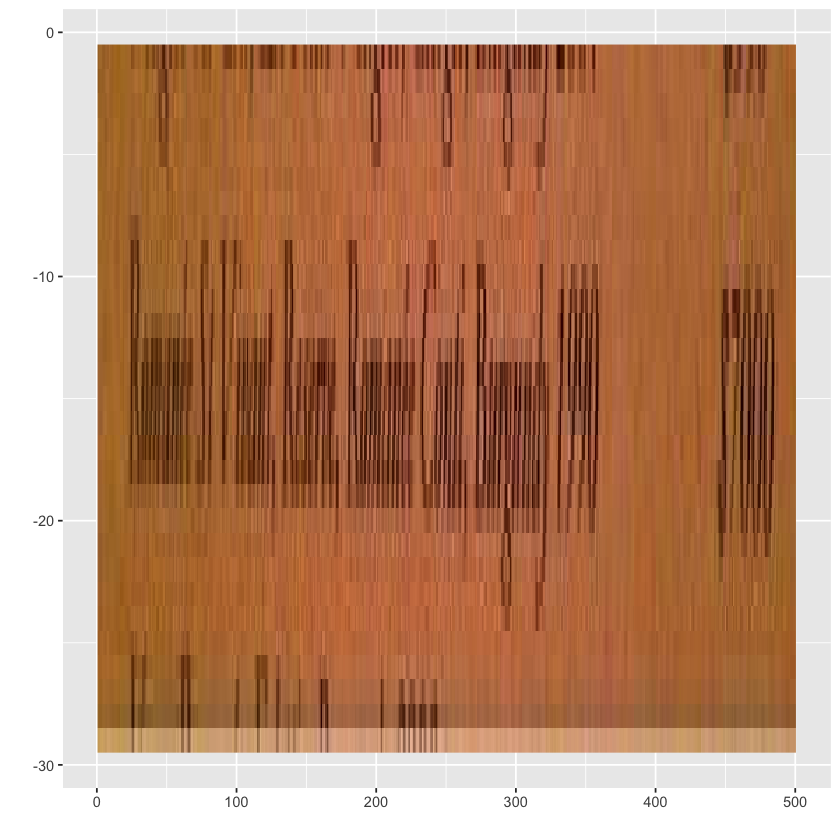

       photo_id .src imgResY imgResX imgResXY imgLumR.mean imgLumR.mad
247618     2733 Test     500     299   149500    0.3681548   0.3837318
       imgLumB.mean imgLumB.mad imgLumG.mean imgLumG.mad  imgCorRB  imgCorBG
247618    0.3122247   0.3372188    0.2886021   0.3023341 0.9523621 0.9875033
        imgCorGR imgCosSmlRB imgCosSmlBG imgCosSmlGR
247618 0.9489031   0.9812627   0.9950928   0.9800179
      photo_id  .src imgResY imgResX imgResXY imgLumR.mean imgLumR.mad
19308   126878 Train     500     373   186500    0.3935506   0.2325647
      imgLumB.mean imgLumB.mad imgLumG.mean imgLumG.mad  imgCorRB  imgCorBG
19308    0.3905007   0.2558212    0.3485584   0.3197765 0.9923347 0.9254643
       imgCorGR imgCosSmlRB imgCosSmlBG imgCosSmlGR
19308 0.8854547   0.9977985   0.9759265   0.9636938
[1] "\nSample images for min.imgResX:"
[1] "  nrow(smpImgs): 1"
       photo_id .src imgResY imgResX imgResXY imgLumR.mean imgLumR.mad
260002   463232 Test      34      53     1802    0.9240974       

ERROR: Error in readJPEG(sprintf("data/photos/%d.jpg", smpImgs[ix, "photo_id"])): unable to open data/photos/NA.jpg


ERROR: Error in file(con, "rb"): cannot open the connection


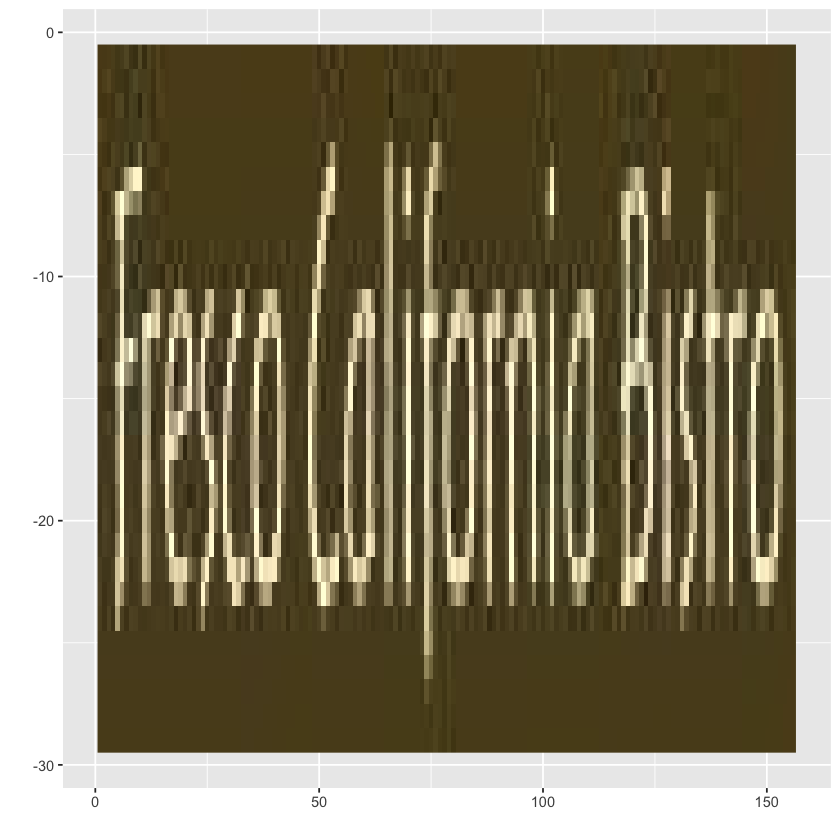

In [37]:
for (feat in grep("^img", names(obsAllImg), value = TRUE)) {
    for (stat in c('min', 'max')) {
        print(sprintf("\nSample images for %s.%s:", stat, feat))
        statVal <- if (stat == 'min') min(obsAllImg[, feat]) else
                                      max(obsAllImg[, feat])
        smpImgs <- obsAllImg[obsAllImg[, feat] == statVal, ]
        print(sprintf("  nrow(smpImgs): %d", nrow(smpImgs)))
        if (nrow(smpImgs) > 3)
            smpImgs <- smpImgs[sample(1:nrow(smpImgs), 3), ]
        for (ix in 1:nrow(smpImgs)) {
            print(smpImgs[ix, ])
            print(myplotImg(img <- readJPEG(sprintf("data/photos/%d.jpg", 
                                                smpImgs[ix, 'photo_id']))))
        }
    }
}        

In [38]:
ftsAllImgBiz <- dplyr::full_join(obsAllImgBiz, obsAllImg)

Joining by: c("photo_id", ".src")


In [39]:
print(nrow(obsAllImgBiz))
print(nrow(ftsAllImgBiz))

[1] 1425067
[1] 1425067


In [40]:
myprint_df(ftsAllImgBiz)

  photo_id business_id  .src   chn imgResY imgResX imgResXY imgLumR.mean
1   204149        3034 Train FALSE     500     373   186500    0.5083072
2    52779        2805 Train FALSE     500     500   250000    0.4169495
3   278973         485 Train FALSE     375     500   187500    0.2577210
4   195284         485 Train FALSE     375     500   187500    0.4568185
5    19992         485 Train FALSE     375     500   187500    0.4356761
6    80748         485 Train FALSE     375     500   187500    0.3330310
  imgLumR.mad imgLumB.mean imgLumB.mad imgLumG.mean imgLumG.mad  imgCorRB
1   0.2267506    0.4673910   0.2965200    0.4154729  0.34884706 0.9679110
2   0.5116424    0.2604018   0.1395388    0.2731843  0.20930824 0.8979718
3   0.1511671    0.1836261   0.0988400    0.1524044  0.05232706 0.9091581
4   0.3197765    0.4619201   0.3255906    0.4241791  0.30814824 0.9783621
5   0.1918659    0.4836980   0.1860518    0.4054324  0.20930824 0.9617356
6   0.1569812    0.2734042   0.1453529    0.2

In [41]:
dupsImg <- 
    obsAllImgBiz[gdata::duplicated2(obsAllImgBiz[, 'photo_id', FALSE]), 
                ] %>%
    dplyr::arrange(photo_id)
dupsImg <- ftsAllImgBiz[ftsAllImgBiz$photo_id %in% 
                        unique(dupsImg[, 'photo_id']), ] %>%
    dplyr::arrange(photo_id)
myprint_df(dupsImg)

  photo_id business_id .src  chn imgResY imgResX imgResXY imgLumR.mean
1        1       3tv9h Test TRUE     375     500   187500    0.4679447
2        1       4udt2 Test TRUE     375     500   187500    0.4679447
3        1       6ou8e Test TRUE     375     500   187500    0.4679447
4        1       jce1v Test TRUE     375     500   187500    0.4679447
5        1       lxz32 Test TRUE     375     500   187500    0.4679447
6        1       y1yxy Test TRUE     375     500   187500    0.4679447
  imgLumR.mad imgLumB.mean imgLumB.mad imgLumG.mean imgLumG.mad imgCorRB
1   0.1802376    0.4250532   0.2209365    0.3998144   0.2441929 0.895771
2   0.1802376    0.4250532   0.2209365    0.3998144   0.2441929 0.895771
3   0.1802376    0.4250532   0.2209365    0.3998144   0.2441929 0.895771
4   0.1802376    0.4250532   0.2209365    0.3998144   0.2441929 0.895771
5   0.1802376    0.4250532   0.2209365    0.3998144   0.2441929 0.895771
6   0.1802376    0.4250532   0.2209365    0.3998144   0.2441929 0

In [42]:
dupsBiz <- 
    obsAllImgBiz[gdata::duplicated2(obsAllImgBiz[, 'business_id', FALSE]), 
                ] %>%
    dplyr::arrange(business_id)
dupsBiz <- ftsAllImgBiz[ftsAllImgBiz$business_id %in% 
                        unique(dupsBiz[, 'business_id']), ] %>%
    dplyr::arrange(business_id)
myprint_df(dupsBiz)

  photo_id business_id .src  chn imgResY imgResX imgResXY imgLumR.mean
1   317818       003sg Test TRUE     500     375   187500    0.5181632
2    30679       003sg Test TRUE     375     500   187500    0.4804461
3   455084       003sg Test TRUE     500     375   187500    0.6026656
4   371381       003sg Test TRUE     500     375   187500    0.2722330
5    86224       003sg Test TRUE     500     500   250000    0.3863622
6    36076       003sg Test TRUE     500     375   187500    0.3831984
  imgLumR.mad imgLumB.mean imgLumB.mad imgLumG.mean imgLumG.mad  imgCorRB
1   0.2441929    0.4822503  0.26163529    0.4302850  0.29070588 0.9718484
2   0.3197765    0.4545408  0.26163529    0.2754346  0.21512235 0.8441429
3   0.2732635    0.5216484  0.36628941    0.4624054  0.31396235 0.9336269
4   0.1337247    0.2173218  0.06395529    0.1018909  0.02907059 0.9698103
5   0.3895459    0.2191734  0.15698118    0.2495149  0.09302588 0.7814994
6   0.2034941    0.2757091  0.14535294    0.2406084  0.1162

In [43]:
nImgsMax <- dplyr::arrange(nImgsAll, desc(nImgs)) %>% head()
myprint_df(nImgsMax)

Source: local data frame [6 x 2]

  business_id nImgs
        (chr) (int)
1        2339  2974
2        1114  2901
3       1zuh9  2825
4       4wby9  2825
5       clr6m  2825
6       fh8b2  2825


In [44]:
grep("^img", names(obsAllImg), value = TRUE)
#print(dim(ftsAllBiz))

[1] "imgResY"      "imgResX"      "imgResXY"     "imgLumR.mean" "imgLumR.mad" 
 [6] "imgLumB.mean" "imgLumB.mad"  "imgLumG.mean" "imgLumG.mad"  "imgCorRB"    
[11] "imgCorBG"     "imgCorGR"     "imgCosSmlRB"  "imgCosSmlBG"  "imgCosSmlGR"

In [46]:
ftsAllBiz <- ftsAllImgBiz %>%
    #dplyr::filter(business_id %in% nImgsMax$business_id) %>%
    dplyr::group_by(business_id) %>%
    dplyr::summarize(
        imgResXLst = do.call(paste0, list(c(imgResX), collapse = ',')),
        imgResYLst = do.call(paste0, list(c(imgResY), collapse = ',')),        
        imgResXYLst = do.call(paste0, list(c(imgResXY), collapse = ',')),        
        
        imgLumR.meanLst = do.call(paste0, list(c(imgLumR.mean), collapse = ',')),
        imgLumR.madLst  = do.call(paste0, list(c(imgLumR.mad ), collapse = ',')),        
        imgLumB.meanLst = do.call(paste0, list(c(imgLumB.mean), collapse = ',')),
        imgLumB.madLst  = do.call(paste0, list(c(imgLumB.mad ), collapse = ',')),        
        imgLumG.meanLst = do.call(paste0, list(c(imgLumG.mean), collapse = ',')),
        imgLumG.madLst  = do.call(paste0, list(c(imgLumG.mad ), collapse = ',')),                
        
        imgCorRBLst = do.call(paste0, list(c(imgCorRB), collapse = ',')),
        imgCorBGLst = do.call(paste0, list(c(imgCorBG), collapse = ',')),
        imgCorGRLst = do.call(paste0, list(c(imgCorGR), collapse = ',')),        
        
        imgCosSmlRBLst = do.call(paste0, list(c(imgCosSmlGR), collapse = ',')),
        imgCosSmlBGLst = do.call(paste0, list(c(imgCosSmlBG), collapse = ',')),        
        imgCosSmlGRLst = do.call(paste0, list(c(imgCosSmlGR), collapse = ',')))

print(dim(ftsAllBiz))
print(names(ftsAllBiz))
myprint_df(ftsAllBiz)
print(head(ftsAllBiz$resXLst, 1))
print(tail(ftsAllBiz$imgCosSmlGRLst, 1))

[1] 12000    16
 [1] "business_id"     "imgResXLst"      "imgResYLst"      "imgResXYLst"    
 [5] "imgLumR.meanLst" "imgLumR.madLst"  "imgLumB.meanLst" "imgLumB.madLst" 
 [9] "imgLumG.meanLst" "imgLumG.madLst"  "imgCorRBLst"     "imgCorBGLst"    
[13] "imgCorGRLst"     "imgCosSmlRBLst"  "imgCosSmlBGLst"  "imgCosSmlGRLst" 
Source: local data frame [6 x 16]

  business_id
        (chr)
1       003sg
2       00er5
3       00kad
4       00mc6
5       00q7x
6       00v0t
Variables not shown: imgResXLst (chr), imgResYLst (chr), imgResXYLst (chr),
  imgLumR.meanLst (chr), imgLumR.madLst (chr), imgLumB.meanLst (chr),
  imgLumB.madLst (chr), imgLumG.meanLst (chr), imgLumG.madLst (chr),
  imgCorRBLst (chr), imgCorBGLst (chr), imgCorGRLst (chr), imgCosSmlRBLst
  (chr), imgCosSmlBGLst (chr), imgCosSmlGRLst (chr)
Source: local data frame [6 x 16]

  business_id
        (chr)
1        2159
2       5c1an
3       63893
4       mhyav
5       w3dm8
6       yivrj
Variables not shown: imgResXLst (chr), im

In [48]:
obsAll <- dplyr::left_join(obsAll, ftsAllBiz)
print(dim(obsAll))
print(summary(obsAll))
#print(tapply(obsAll, obsAll$.src, summary))
myprint_df(obsAll)

Joining by: "business_id"


[1] 12000    19
 business_id                  labels          .src               nImgs       
 Length:12000       1 2 4 5 6 7  :  157   Length:12000       Min.   :   1.0  
 Class :character   0 3 8        :  137   Class :character   1st Qu.:  32.0  
 Mode  :character   1 2 3 4 5 6 7:  136   Mode  :character   Median :  60.0  
                    0 8          :  129                      Mean   : 118.8  
                    3 8          :   95                      3rd Qu.: 120.0  
                    (Other)      : 1346                      Max.   :2974.0  
                    NA's         :10000                                      
  imgResXLst         imgResYLst        imgResXYLst        imgLumR.meanLst   
 Length:12000       Length:12000       Length:12000       Length:12000      
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                    

### Output data for classifiers

In [49]:
# write.table(subset(obsAll, .src == "Train", select = -.src),
#           "data/train_resXY.csv", row.names = FALSE, quote = TRUE, 
#           sep = ',')
write.csv(subset(obsAll, .src == "Train", select = -.src),
          "data/train_color.csv", row.names = FALSE)
write.csv(subset(obsAll, .src == "Test" , select = -.src) %>% 
          subset(select = -labels),
          "data/test_color.csv" , row.names = FALSE)

In [50]:
print(sessionInfo())
print(format(Sys.time(), "(%a) %b %d, %Y"))

R version 3.2.2 (2015-08-14)
Platform: x86_64-apple-darwin15.0.0 (64-bit)
Running under: OS X 10.11.3 (El Capitan)

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] proxy_0.4-15    doBy_4.5-14     survival_2.38-3 reshape2_1.4.1 
 [5] jpeg_0.1-8      ggplot2_2.0.0   dplyr_0.4.3     Cairo_1.5-9    
 [9] doMC_1.3.4      iterators_1.0.8 foreach_1.4.3  

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.3        compiler_3.2.2     nloptr_1.0.4       plyr_1.8.3        
 [5] base64enc_0.1-3    tools_3.2.2        rpart_4.1-10       lme4_1.1-10       
 [9] digest_0.6.9       uuid_0.1-2         jsonlite_0.9.19    evaluate_0.8      
[13] nlme_3.1-124       gtable_0.1.2       lattice_0.20-33    mgcv_1.8-11       
[17] Matrix_1.2-3       DBI_0.3.1          IRdisplay_0.3      IRkernel_0.5      
[21] SparseM_1.7        rzmq_0.